In [31]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os
import numpy as np

class MultimodalHouseDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.data['image_exists'] = self.data['id'].apply(
            lambda x: os.path.exists(os.path.join(img_dir, f"{int(x)}.jpg"))
        )
        self.data = self.data[self.data['image_exists'] == True].reset_index(drop=True)
        print(f"Dataset initialized with {len(self.data)} samples.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature_cols = [c for c in self.data.columns if c not in ['id', 'price', 'price_log', 'image_exists']]
        
        # FIX: float32 conversion 
        tabular_values = self.data.iloc[idx][feature_cols].values.astype(np.float32)
        tabular_data = torch.tensor(tabular_values, dtype=torch.float)
        
        label = torch.tensor(float(self.data.iloc[idx]['price_log']), dtype=torch.float)
        
        img_id = int(self.data.iloc[idx]['id'])
        image = Image.open(os.path.join(self.img_dir, f"{img_id}.jpg")).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        return image, tabular_data, label

print("Dataset Class Defined.")

Dataset Class Defined.


In [33]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = MultimodalHouseDataset(csv_file='Data/cleaned_data.csv', img_dir='images/')
full_dataset.transform = image_transforms
train_loader = DataLoader(full_dataset, batch_size=16, shuffle=True)

Dataset initialized with 8059 samples.


In [35]:
import torch.nn as nn
from torchvision import models

class MultiModalPriceModel(nn.Module):
    def __init__(self, num_tabular_features):
        super(MultiModalPriceModel, self).__init__()
        
        # 1. Image Branch (CNN) 
        self.cnn = models.resnet18(weights='DEFAULT')
        
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 256) 
        
        # Tabular Branch (MLP) -Processing the house data (bedrooms, sqft, etc.)
        self.mlp = nn.Sequential(
            nn.Linear(num_tabular_features, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # Fusion Head - Combining Image Features (256) + Tabular Features (64)
        # Total = 320 features
        self.fusion = nn.Sequential(
            nn.Linear(256 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1) # Final prediction: The Log Price
        )

    def forward(self, image, tabular):
        img_features = self.cnn(image)
        tab_features = self.mlp(tabular)
        
        combined = torch.cat((img_features, tab_features), dim=1)
        
        # final price prediction
        return self.fusion(combined)

# Initializing the model using 16 features
num_features = 16 
model = MultiModalPriceModel(num_features)

print(" Model Architecture is ready!")

 Model Architecture is ready!


In [37]:
model = MultiModalPriceModel(num_tabular_features=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

print("--- Training Started ---")
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, tabular, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, tabular).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), 'best_multimodal_model.pth')

--- Training Started ---
Epoch 1, Loss: 8.3089
Epoch 2, Loss: 0.1021
Epoch 3, Loss: 0.0608
Epoch 4, Loss: 0.0456
Epoch 5, Loss: 0.0396
Epoch 6, Loss: 0.0390
Epoch 7, Loss: 0.0354
Epoch 8, Loss: 0.0359
Epoch 9, Loss: 0.0374
Epoch 10, Loss: 0.0334


In [39]:
!python data_fetcher.py


100%|##########| 8000/8000 [00:00<00:00, 34129.31it/s]

100%|##########| 5404/5404 [46:36<00:00,  1.93it/s]


In [59]:

generate_predictions('Data/test2.xlsx', 'images/', 'best_multimodal_model.pth', 'final_predictions.csv')

Starting predictions on test set...
Success! Predictions saved to final_predictions.csv


In [43]:
import pandas as pd
results = pd.read_csv('final_predictions.csv')
print(results.head())

           id  predicted_price
0  2591820310     4.813245e+05
1  7974200820     7.779752e+05
2  7701450110     1.153157e+06
3  9522300010     1.570457e+06
4  9510861140     8.947399e+05


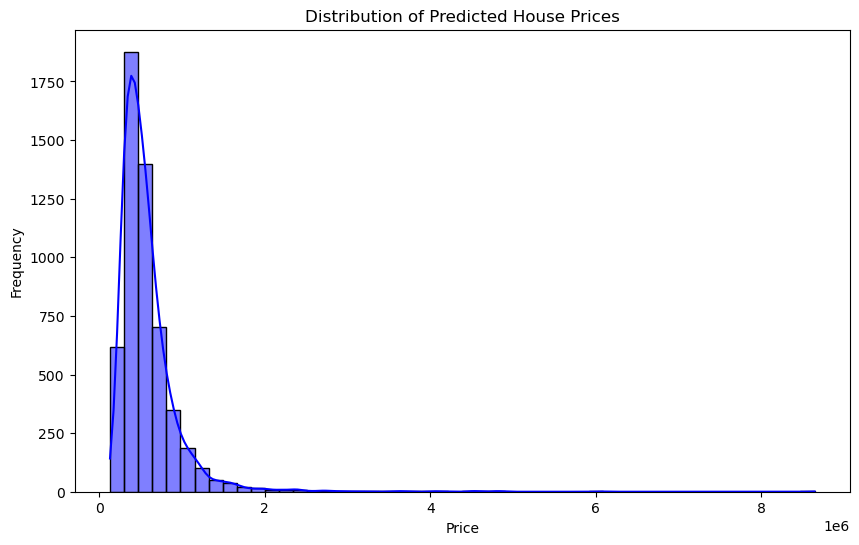

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

results = pd.read_csv('final_predictions.csv')

plt.figure(figsize=(10, 6))
sns.histplot(results['predicted_price'], bins=50, kde=True, color='blue')
plt.title('Distribution of Predicted House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

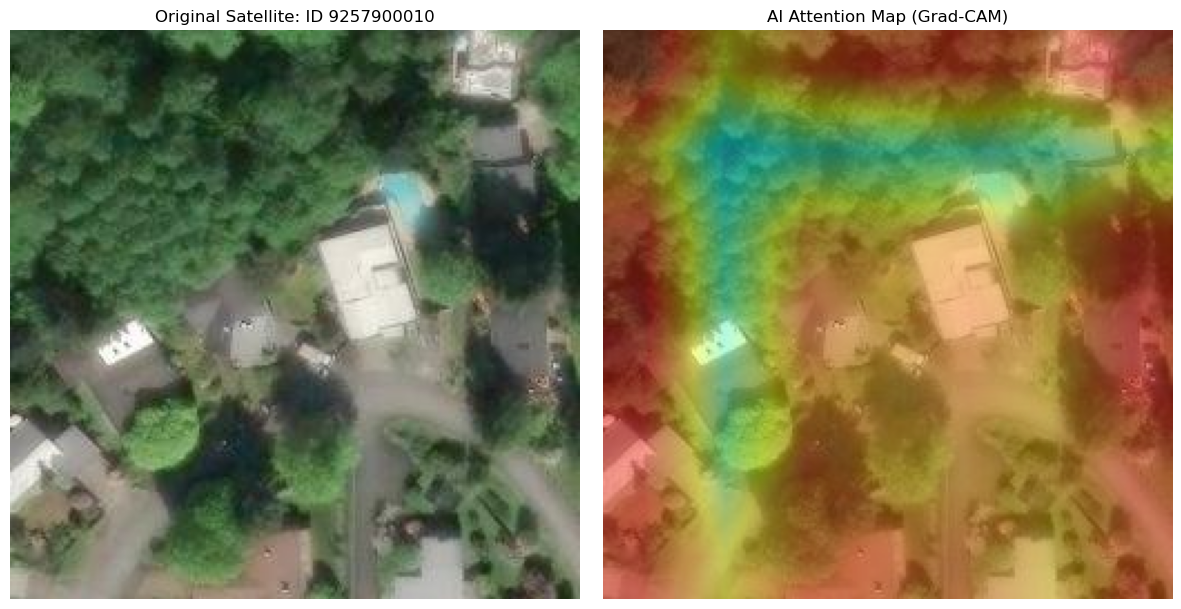

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

def show_explainability_v2(model, dataset_index):
    model.eval()
    
    
    image_tensor, tab_tensor, target = full_dataset[dataset_index]
    img_id = int(full_dataset.data.iloc[dataset_index]['id'])
    
    # 2. Setup Hook to capture features from the last CNN layer
    features = []
    def hook(module, input, output):
        features.append(output)
    
    # We hook into layer4 of ResNet18 (the last convolutional block)
    handle = model.cnn.layer4.register_forward_hook(hook)
    
    # 3. Forward Pass
    output = model(image_tensor.unsqueeze(0), tab_tensor.unsqueeze(0))
    
    # 4. Generate Heatmap
    feature_map = features[0].detach().cpu().numpy()[0]
    heatmap = np.mean(feature_map, axis=0) 
    heatmap = np.maximum(heatmap, 0)       
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)         
    
    
    
    img_path = f'images/{img_id}.jpg'
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    
    
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    
    # Overlay (60% original image, 40% heatmap)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)
    
    # Results
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Original Satellite: ID {img_id}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("AI Attention Map (Grad-CAM)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    handle.remove() # Clean up the hook


show_explainability_v2(model, 50)

In [55]:
import pandas as pd
res = pd.read_csv('final_predictions.csv')
print(f"Successfully generated {len(res)} predictions!")
print(f" Average House Price: {res['predicted_price'].mean():,.2f}")

Successfully generated 5404 predictions!
 Average House Price: 577,719.70


In [57]:
import os
os.rename('final_predictions.csv', '23117143_final.csv') 